In [5]:
import torch
import matplotlib.pyplot as plt

In [253]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

#### mean-shift algo
<br/>
<li> goal: cluster the nearby data points using "mean shift algo" </li>
<li> algo: </li>
<div>
    
        1) find distance between each data point to every other data points.
        
        2) use weight function to penalize or reduce the weights for the distant data points.
        
        3) take the weighter avg of all the distance, and update this weighter distance for the point.
        
        4) repeat this for all points
        
        5) do this some number of iteration again and again
    
    
    
<div>
<li> intution: </li>
<div>
    
        when we do the weighted avg of the distance for each point against each other points, close points
        tend to move closer together, and distant points move further away at each iteration. so after certain
        number of iteration it will create group of distinct clusters which are composed of closer data points.

</div>

#### synthetic data

In [332]:
n_clusters = 6 
n_samples = 250
dim = 2

In [333]:
centroids = torch.randn(n_clusters, dim)*70 - 35

In [334]:
centroids.max(dim=0), centroids.min(dim=0), centroids.mean(dim=0), centroids.std(dim=0)

(torch.return_types.max(
 values=tensor([34.82, -0.20]),
 indices=tensor([3, 3])),
 torch.return_types.min(
 values=tensor([ -99.35, -117.06]),
 indices=tensor([0, 5])),
 tensor([-32.40, -30.12]),
 tensor([52.13, 45.10]))

In [335]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [336]:
def sample(m):
    return MultivariateNormal(loc=m, covariance_matrix=torch.diag(torch.tensor([5., 5.]))).sample((n_samples,))

In [337]:
slices = [sample(c) for c in centroids]

In [338]:
slices = torch.cat(slices)

In [339]:
slices.shape

torch.Size([1500, 2])

In [340]:
def plot_data(centroids, data, n_samples, ax=None):
    if not ax:
        _, ax = plt.subplots(figsize=(20, 8))
       
    for i, c in enumerate(centroids):
        sample = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(sample[:,0], sample[:,1], s=10)
        ax.plot(*c, marker='x', markersize=10, color='k', mew=5)
        ax.plot(*c, marker='x', markersize=5, color='m', mew=2)        

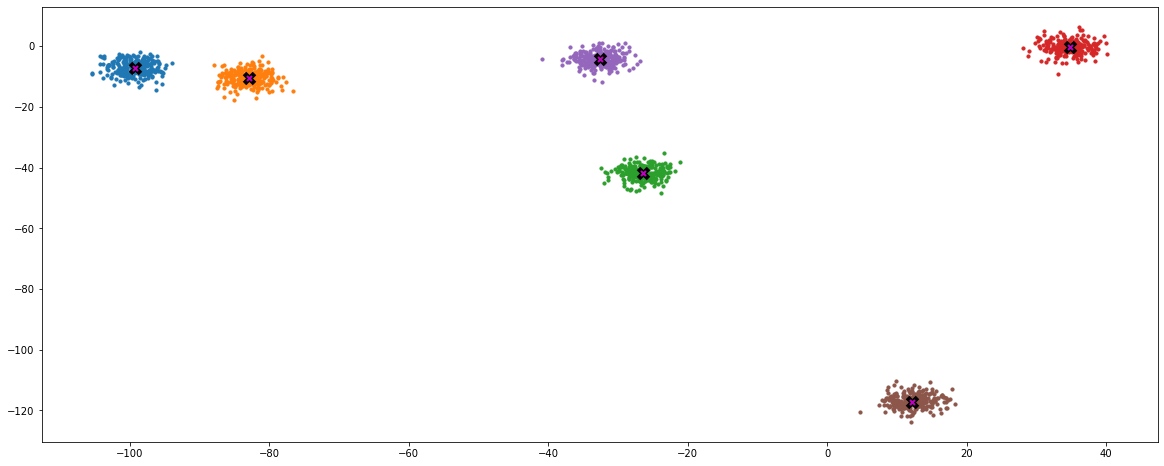

In [341]:
plot_data(centroids, slices, n_samples)

#### algo

In [342]:
import math

In [343]:
# distance weighting function
def gaussian_kernel(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [344]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))

In [345]:
from functools import partial

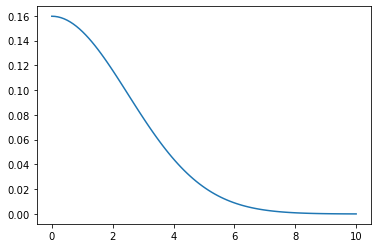

In [346]:
plot_func(partial(gaussian_kernel, bw=2.5))

In [347]:
# distance weighting function
def tri(d, i):
    return (-d+i).clamp_min(0)/i

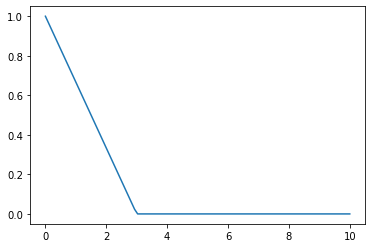

In [348]:
plot_func(partial(tri, i=3))

In [349]:
X = slices.clone()

In [350]:
x = X[0]
x

tensor([-103.10,   -6.25])

In [351]:
dist = ((x.view(1, -1) - X)**2).sum(1).sqrt()

In [352]:
dist.shape

torch.Size([1500])

In [353]:
dist[:8]

tensor([0.00, 5.61, 8.41, 2.33, 1.23, 3.60, 6.29, 2.49])

In [354]:
weights = gaussian_kernel(dist, 2.5)

In [355]:
weights.shape

torch.Size([1500])

In [356]:
weights[:8]

tensor([0.16, 0.01, 0.00, 0.10, 0.14, 0.06, 0.01, 0.10])

In [357]:
weights.view(-1, 1).shape

torch.Size([1500, 1])

In [358]:
(weights.view(-1, 1) * X).sum(0)/weights.sum()

tensor([-101.07,   -6.66])

In [359]:
weights.sum()

tensor(10.88)

In [360]:
def one_update(X):
    for i, x in enumerate(X):
        dist = ((x.view(1, -1)-X)**2).sum(1).sqrt()
        weights = gaussian_kernel(dist, 2.5)
        X[i] = (weights.view(-1, 1)*X).sum(0)/weights.sum()

In [363]:
def mean_shift(data):
    X = data.clone()
    for it in range(10):
        one_update(X)
        
    plot_data(centroids+2, X, n_samples=n_samples)

CPU times: user 1.53 s, sys: 8.1 ms, total: 1.53 s
Wall time: 1.53 s


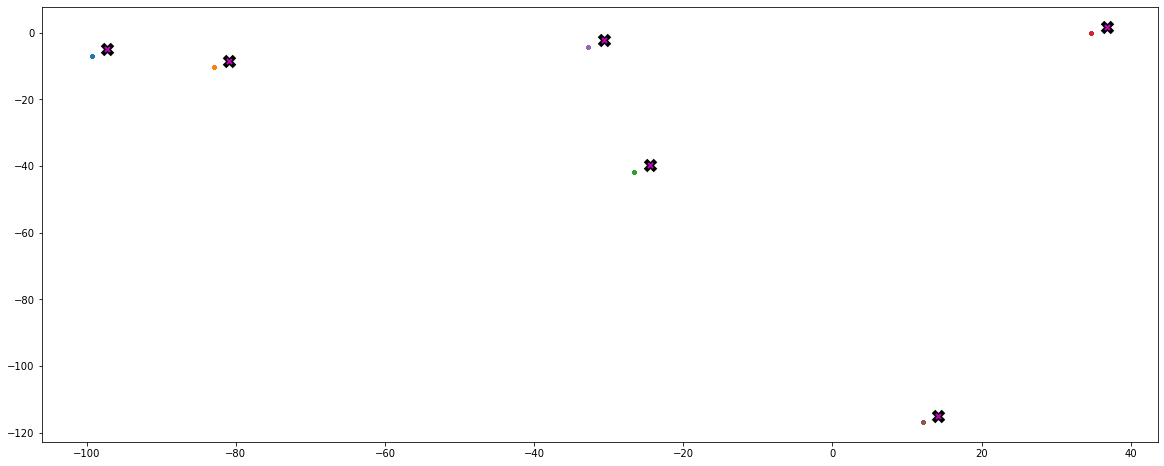

In [364]:
%time mean_shift(slices)

#### GPU batched algo

In [468]:
bs = 5
X = slices.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [481]:
def dist_b(a, b):
    return ((a[None] - b[:,None])**2).sum(2).sqrt()

In [482]:
dist_b(X, x).shape

torch.Size([5, 1500])

<code>

rule-1:
      X = (1, 1500, 2)
      x = (5, 1, 2)
rule-2:
      X = (1, 1500, 2) => (5, 1500, 2) 
      x = (5, 1, 2) => (5, 1500, 2)
rule-3:
     * both shape matches so we can perform the broadcasting rue
    
</code>

In [483]:
weight = gaussian_kernel(dist_b(X, x), 2)

In [485]:
weight.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

#### broadcasting test

In [404]:
import numpy as np

In [407]:
a = np.array([
    0, 1, 2
])
b = np.array([
    5, 5, 5
])
a.shape, b.shape

((3,), (3,))

In [406]:
a + b

array([5, 6, 7])

In [408]:
a + 5

array([5, 6, 7])

In [413]:
M = np.ones((3, 3))
M

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [415]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

In [420]:
M.shape, a.shape

((3, 3), (3,))

<code>3, 3
   3  =>  3, 3
          3, 3</code>

In [430]:
a = np.arange(3)
b = np.arange(3)[:,np.newaxis]

In [432]:
a.shape, b.shape

((3,), (3, 1))

In [433]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

In [434]:
a, b

(array([0, 1, 2]),
 array([[0],
        [1],
        [2]]))

In [440]:
M = np.ones((2, 3))
a = np.arange(3)

In [441]:
M.shape, a.shape

((2, 3), (3,))

In [442]:
M

array([[1., 1., 1.],
       [1., 1., 1.]])

In [443]:
a

array([0, 1, 2])

<code>
rule 1: array has less dim so pad with 1 at leading left side
        a = (3,) => (1, 3)

rule 3: compare each dim of a and M and copy the deficient dim with the same value
        M = (2, 3)
        a = (1, 3) => (2, 3) * here 1st dim is deficient so it got filled up with the second dim
</code>  

In [446]:
(M + a), (M + a).shape

(array([[1., 2., 3.],
        [1., 2., 3.]]),
 (2, 3))

In [451]:
a = np.arange(3).reshape(3, 1)
b = np.arange(3)
a.shape, b.shape

((3, 1), (3,))

<code>

rule-1:
    (3, 1)
    (3,) => (1, 3)

rule-2:
    (3, 1) => (3, 3) * here column got copied
    (1, 3) => (3, 3) * here rwo got copied
    
</code>

In [452]:
(a+b), (a+b).shape

(array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4]]),
 (3, 3))

In [453]:
M = np.ones((3, 2))
a = np.arange(3)
a.shape, M.shape

((3,), (3, 2))

<code>
    
rule-1:
    (3, 2)
    (3,) => (1, 3)
    
rule-2:
    (3, 2)
    (1, 3) 
 
rule-3:
    * both shapes are not matching
    * both are not compatible, because first dim fine, but second dim not matching so, you can't do the broadcasting

</code>

In [457]:
a + M

ValueError: operands could not be broadcast together with shapes (3,) (3,2) 

In [458]:
# use braoadcasting for mean centering

In [460]:
X = np.random.random((10, 3))
X.shape

(10, 3)

In [461]:
mean = X.mean(0)
mean

array([0.53842755, 0.74584377, 0.33992809])

In [463]:
mean.shape, X.shape

((3,), (10, 3))

In [466]:
(X - mean).mean(0)

array([-3.33066907e-17, -1.77635684e-16, -4.44089210e-17])